載入模型所必須要的相依套件

In [13]:
import torch
import transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from transformers import BertModel, BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

%matplotlib inline


讀取先求有data_extract.py所處理完的資料，並將資料區分成train(49500筆)與validate(500筆)兩個部分

In [8]:
TRAIN = pd.read_json("./data/train.json")
TRAIN = TRAIN.sample(frac=1).reset_index(drop=True)
VAL = pd.read_json("./data/test.json")
VAL = VAL.sample(frac=1).reset_index(drop=True)
TRAIN = TRAIN.append(VAL[500:]).reset_index(drop=True)
VAL = VAL.iloc[:500]


In [9]:
TRAIN.head()

,comment,score
0,Titanic directed by James Cameron presents a f...,9
1,I have nothing against a fast-paced fright-fli...,3
2,SPOILER ALERT!!!!<br /><br />I had just watche...,10
3,"Once again, like Charlie's Angels, Inspector G...",2
4,"It' just funny, watch it!!! <br /><br />OK the...",10


查看資料集的基礎屬性

In [11]:
TRAIN.info()
VAL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49500 entries, 0 to 49499
Data columns (total 2 columns):
comment    49500 non-null object
score      49500 non-null int64
dtypes: int64(1), object(1)
memory usage: 773.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
comment    500 non-null object
score      500 non-null int64
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


匯出資料及的標籤值(label)分布情形

Text(0.5, 0, 'review score')

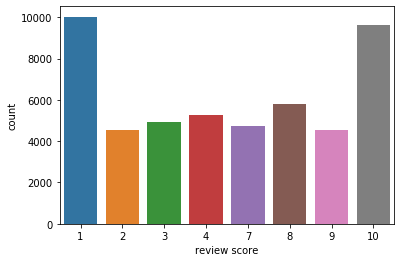

In [15]:
sns.countplot(TRAIN.score)
plt.xlabel('review score')

選擇所使用的育訓練模型中所搭配的分詞器(Tokenizer)

In [16]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
TOKENIZER = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

查看一般語句在BERT Tokenizer分詞過後的情形

In [51]:
text = TRAIN.comment[0][:250]

tokens = TOKENIZER.tokenize(text)
token_ids = TOKENIZER.convert_tokens_to_ids(tokens)

print(tokens[:50])
print(token_ids[:50])

['Titanic', 'directed', 'by', 'James', 'Cameron', 'presents', 'a', 'fictional', 'love', 'story', 'on', 'the', 'historical', 'setting', 'of', 'the', 'Titanic', '.', 'The', 'plot', 'is', 'simple', ',', 'non', '##com', '##plicate', '##d', ',', 'or', 'not', 'for', 'those', 'who', 'love', 'plots', 'that', 'twist', 'and', 'turn', 'and', 'keep', 'you', 'in', 'su', '##spense', '.', 'The', 'end', 'of', 'the']
[24342, 2002, 1118, 1600, 6681, 8218, 170, 6725, 1567, 1642, 1113, 1103, 3009, 3545, 1104, 1103, 24342, 119, 1109, 4928, 1110, 3014, 117, 1664, 8178, 21379, 1181, 117, 1137, 1136, 1111, 1343, 1150, 1567, 15836, 1115, 11079, 1105, 1885, 1105, 1712, 1128, 1107, 28117, 21643, 119, 1109, 1322, 1104, 1103]


差看各個特殊Token在BERT分詞器中的編碼

In [52]:
print(TOKENIZER.sep_token, TOKENIZER.sep_token_id)
print(TOKENIZER.cls_token, TOKENIZER.cls_token_id)
print(TOKENIZER.pad_token, TOKENIZER.pad_token_id)
print(TOKENIZER.unk_token, TOKENIZER.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


依照資料及各筆語料分詞過後的長度選擇最大編碼長度(MAX_SEQ_LEN)

In [44]:
TRAIN["token_number"] = TRAIN["comment"].apply(TOKENIZER.tokenize).apply(len)
TRAIN["token_number"].describe()

count    49500.000000
mean       317.248424
std        238.372051
min          8.000000
25%        169.000000
50%        236.000000
75%        386.000000
max       3238.000000
Name: token_number, dtype: float64

In [53]:
MAX_SEQ_LEN = 160

BERT分詞器編碼的範例，其產生物件包含input_ids與attention_mask

In [54]:
encoding = TOKENIZER.encode_plus(
  text,
  max_length=MAX_SEQ_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)


tensor([[  101, 24342,  2002,  1118,  1600,  6681,  8218,   170,  6725,  1567,
          1642,  1113,  1103,  3009,  3545,  1104,  1103, 24342,   119,  1109,
          4928,  1110,  3014,   117,  1664,  8178, 21379,  1181,   117,  1137,
          1136,  1111,  1343,  1150,  1567, 15836,  1115, 11079,  1105,  1885,
          1105,  1712,  1128,  1107, 28117, 21643,   119,  1109,  1322,  1104,
          1103,  2523,  1169,  1129,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

查看編碼的原型: [CLS]...[SEP]....

In [59]:
print(TOKENIZER.convert_ids_to_tokens(encoding["input_ids"][0]))

['[CLS]', 'Titanic', 'directed', 'by', 'James', 'Cameron', 'presents', 'a', 'fictional', 'love', 'story', 'on', 'the', 'historical', 'setting', 'of', 'the', 'Titanic', '.', 'The', 'plot', 'is', 'simple', ',', 'non', '##com', '##plicate', '##d', ',', 'or', 'not', 'for', 'those', 'who', 'love', 'plots', 'that', 'twist', 'and', 'turn', 'and', 'keep', 'you', 'in', 'su', '##spense', '.', 'The', 'end', 'of', 'the', 'movie', 'can', 'be', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'